# Deep Learning &mdash; Assignment 6

Assignment for week 6 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a graph neural network, using pytorch geometric
2. Compare a GNN with other network architectures
3. Compare different GNN layers and aggregation functions

## Required software

As before you will need these libraries:
* `torch`, `torch-sparse`, `torch-scatter`, and `torch-geometric` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

The recommended way to install these libraries is described in the [torch-geometric installation instructions](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [15]:
# Replace ${TORCH} and ${CUDA} with your torch and cuda versions.
# Or remove the -f argument to compile from source
#
#!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
#!pip install torch-geometric

In [16]:
from torch_geometric.utils import to_dense_adj, dense_to_sparse
%config InlineBackend.figure_formats =['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch import nn
from torch.nn import Linear, Dropout
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

## 6.1 A node classification dataset (1 point)

In this assignment we will be working on a node classification problem using the Citeseer dataset. This is a graph dataset that contains bag-of-words representation of documents and citation links between the documents. So there is an edge between document $i$ and document $j$ if one cites the other. This is an undirected edge.

In [17]:
dataset = Planetoid(root='data', name='Citeseer', transform=NormalizeFeatures())

**(a) How many graphs are there in this dataset? How large are they (in terms of nodes and edges)?<span style="float:right"> (1 point)</span>**

In [18]:
print(f'Number of graphs: {dataset.len()}')
print(f'Number of nodes: {dataset[0].num_nodes}, number of edges: {dataset[0].num_edges}')

Number of graphs: 1
Number of nodes: 3327, number of edges: 9104


In fact, we will continue the rest of this notebook using the first graph from the dataset.

In [19]:
data = dataset[0]  # Get the first graph object.

We will be use a subset of the nodes for training, and another subset for testing.
These subsets are indicated by `data.train_mask` and `data.test_mask` respectively.

## 6.2 MLP for node classification (6 points)

In theory, we should be able to classify documents based only on their content, that is, using the bag-of-words features, without taking the graph structure into account.

We can verify that by constructing a simple node-wise multilayer perceptron with a single hidden layer. This network does not use the edge information at all.

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

The network should have 2 linear layers. The hidden layer should have size `hidden_channels`, use ReLU activations, and use dropout with a dropout rate of 0.1. Don't use an activation function after the final layer.

Hint: avoid using `Sequential`, it will make the assignment harder later on.

In [20]:
class MLP(torch.nn.Module):
    def __init__(self, num_features: int, num_classes: int, hidden_channels=16):
        super().__init__()
        self.linear1 = nn.Linear(num_features, hidden_channels)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

**(b) Complete the training loop below.<span style="float:right"> (2 points)</span>**

Hint: compute the loss only on the training nodes.

Hint 2: `data.x` contains the features for each node, `data.y` contains their labels.

Hint 3: `model()` takes two parameters: a tensor of node features, and a tensor of edges. See the `test_accuracy` function.

In [21]:
print(data.x.shape)
print(data.y.shape)
print(data.edge_index.shape)
print(data)
print(data.x[data.train_mask].shape)
print(to_dense_adj(data.edge_index)[0][data.train_mask].T[data.train_mask].shape)
print(dense_to_sparse(to_dense_adj(data.edge_index)[0][data.train_mask].T[data.train_mask])[0])
# data.x.detach().numpy()
torch.max(data.x)

torch.Size([3327, 3703])
torch.Size([3327])
torch.Size([2, 9104])
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
torch.Size([120, 3703])
torch.Size([120, 120])
tensor([[ 12,  32,  34,  35,  53,  61,  75,  89,  90,  95,  96, 110, 113, 118,
         118, 119],
        [113, 118,  75,  89,  61,  53,  34,  35, 118, 110, 119,  95,  12,  32,
          90,  96]])


tensor(0.1250)

In [22]:
# device = d2l.try_gpu()
device = 'cpu'

def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)


def test(model: nn.Module, data):
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        # Compute loss and accuracy only on the 'test' nodes
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        # Compute loss and accuracy only on the 'train' nodes
        train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
        return train_loss, train_acc, test_loss, test_acc


def train(model: nn.Module, data, lr=0.01, weight_decay=5e-4, epochs=400, plot=True):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()
    if plot:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], figsize=(10, 5),
                                legend=['train loss', 'train accuracy', 'test loss', 'test accuracy'])

    for epoch in range(1, epochs + 1):
        model.train()

        # edge_index = dense_to_sparse(to_dense_adj(data.edge_index)[0][data.train_mask].T[data.train_mask])[
        #     0]
        # y_hat = model(data.x[data.train_mask], edge_index)
        # loss = loss_fn(y_hat, data.y[data.train_mask])
        y_hat = model(data.x, data.edge_index)
        loss = loss_fn(y_hat[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute test accuracy, and plot
        if plot and epoch % 10 == 0:
            train_loss, train_acc, test_loss, test_acc = test(model, data)
            animator.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))

    # Print final accuracy
    train_loss, train_acc, test_loss, test_acc = test(model, data)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

**(c) Now construct and train an MLP on this dataset.<span style="float:right"> (1 point)</span>**

Train loss: 0.0833, Train accuracy: 1.0000
Test loss: 1.2349, Test accuracy: 0.5860


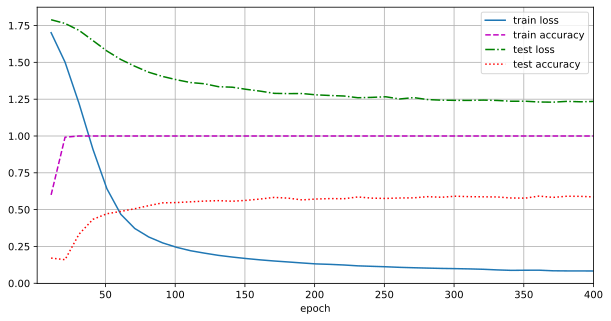

In [23]:
mlp_model = MLP(data.x.shape[1], torch.unique(data.y).shape[0])
train(mlp_model, data)

**(d) The MLP network does not use the citation information at all. Give a way to incorporate the edge information without using a graph neural network?<span style="float:right"> (1 point)</span>**

Note that the method should still work for arbitrary citation graphs.

Add an adjacency matrix as additional features to the MLP, where every feature represents if this paper cites or was cited by another paper.

## 6.3 A graph convolutional neural network (3 points)

Next, we will use a graph neural network based on the Graph Convolutional Network approach, which was introduced in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

**(a) Implement a graph convolutional neural network, by replacing the linear layers in the MLP with [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), and train the network.<span style="float:right"> (1 point)</span>**

The network should have two `GCNConv` layers. The rest of the architecture should stay as close as possible to the MLP.

Train loss: 0.1837, Train accuracy: 1.0000
Test loss: 0.9561, Test accuracy: 0.7120


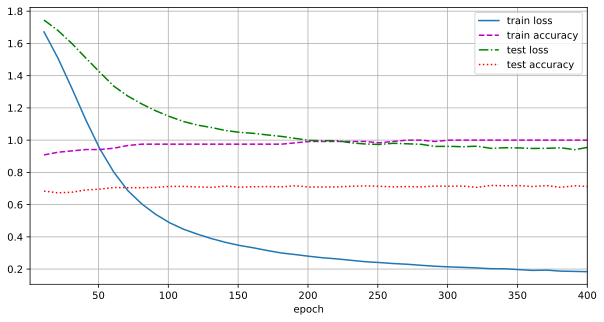

In [24]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=16):
        super().__init__()
        self.gcn1 = torch_geometric.nn.GCNConv(num_features, hidden_channels)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.gcn2 = torch_geometric.nn.GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        return self.gcn2(self.dropout(self.relu(self.gcn1(x, edge_index))), edge_index)


gcn_model = GCN(data.x.shape[1], torch.unique(data.y).shape[0])
train(gcn_model, data)

**(b) Compare the results of the MLP and the GCN. Which model is better?<span style="float:right"> (1 point)</span>**

The GCN network performs slightly better, but there is not a big difference in performance. Both networks do overfit a lot and the accuracy is bad.

**(c) Has the GCN training converged? Can you expect higher test accuracies by training longer? Explain your answer.<span style="float:right"> (1 point)</span>**

The GCN training did not 100% converge after 400 iterations, but it also did change a lot anymore. We do not expect any major improvements when training further, as the test accuracy has already converged and the network is probably only continuing overfitting. Additionally, we don't have a lot of data to train on (only 200), so we do not expect the network to learn more.

## 6.4 Comparing GNN layers (8 points)

Two graph layers that are interesting to compare are [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). Aside from one of them supporting weighted graphs, these models differ only in the accumulation function.

**(a) Look at the documentation for these two layers. What is the difference in the accumulation function?<span style="float:right"> (1 point)</span>**

`SAGEConv` uses the mean as the accumulation function while `GraphConv` uses the sum as the accumulation function.

To avoid having to copy the GNN structure every time, we can make our code generic in the type of layer to use.

**(b) Make a generic graph neural network, that uses layers of type `layer_type`.<span style="float:right"> (1 point)</span>**

Hint: you can construct layers with `my_layer = layer_type(in_size, out_size, **layer_args)`.

In [25]:
class GNN(torch.nn.Module):
    def __init__(self, layer_type, num_features, num_classes, hidden_channels=16, **layer_args):
        super().__init__()
        self.gnn1 = layer_type(num_features, hidden_channels, **layer_args)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.gnn2 = layer_type(hidden_channels, num_classes, **layer_args)

    def forward(self, x, edge_index):
        return self.gnn2(self.dropout(self.relu(self.gnn1(x, edge_index))), edge_index)

**(c) Train a SAGEConv network and a GraphConv network.<span style="float:right"> (no points)</span>**

Train loss: 0.0496, Train accuracy: 1.0000
Test loss: 0.9295, Test accuracy: 0.7070


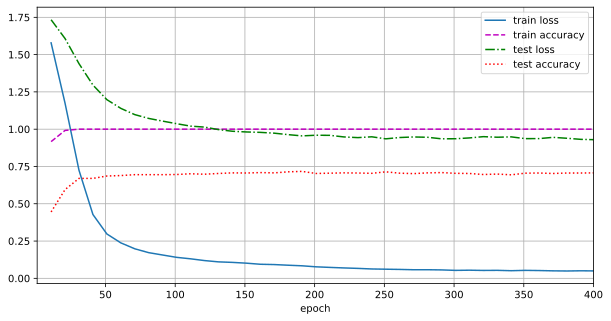

In [26]:
# construct and train a GNN with SAGEConv layers
sageconv_model = GNN(SAGEConv, data.x.shape[1], torch.unique(data.y).shape[0])
train(sageconv_model, data)

Train loss: 0.0324, Train accuracy: 0.9917
Test loss: 1.4147, Test accuracy: 0.6500


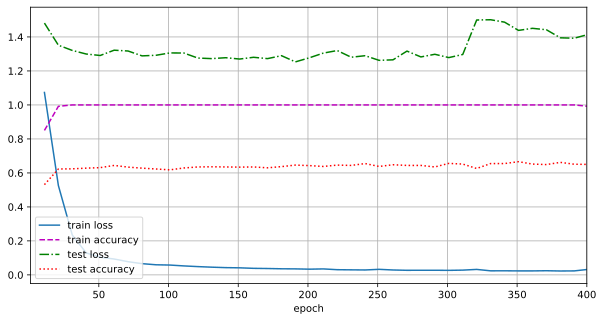

In [27]:
# construct and train a GNN with GraphConv layers
graphconv_model = GNN(GraphConv, data.x.shape[1], torch.unique(data.y).shape[0])
train(graphconv_model, data)

**(d) Compare the performance of these two models, and also compare them to the GCN.<span style="float:right"> (1 point)</span>**

Hint: look at the test loss.

| Net       | test loss | test accuracy |
|-----------|-----------|---------------| 
| GCN       | 0.9574    | 0.7130        |
| SAGEConv  | 0.9286    | 0.7040        |
| GraphConv | 1.3523    | 0.6430        |

The networks do all perform relatively similar. The SAGEConv has the lowest test loss, GCN is very close to that, and GraphConv has a significantly higher test loss. In terms of test accuracy, the GCN performs the best, followed by the SAGEConv and GraphConv.

**(e) Can you explain the observation in the previous question by looking at the aggregation functions? Why is one of them worse than the others?<span style="float:right"> (1 point)</span>**

It seems that the `mean` aggregation is performing better than the `sum`. This is because the sum is heavily influenced by the number of edges connected to the node, while the mean is independent for that. Instead, the mean actually measures how often a word is present in the connected papers.

In fact, it is possible to use different aggregation functions, by passing `aggr=` to the network constructor.

**(f) Compute the performance for `GraphConv` networks with `'mean'`, `'sum'`, `'min'`, `'max'`, and `'std'` aggregation.<span style="float:right"> (1 point)</span>**

Hint: train with `plot=False` to only show the final loss and accuracy.

Hint 2: if the performance is the same for all methods, there is most likely a bug in your `GNN` code.

In [28]:
for aggr in ['mean', 'sum', 'min', 'max', 'std']:
    print(f"Aggregation method: {aggr}")
    graphconv_model = GNN(GraphConv, data.x.shape[1], torch.unique(data.y).shape[0], aggr=aggr)
    train(graphconv_model, data, plot=False)
    print("---\n")

Aggregation method: mean
Train loss: 0.0521, Train accuracy: 1.0000
Test loss: 0.9162, Test accuracy: 0.7090
---

Aggregation method: sum
Train loss: 0.0612, Train accuracy: 0.9917
Test loss: 1.4013, Test accuracy: 0.6480
---

Aggregation method: min
Train loss: 0.0492, Train accuracy: 1.0000
Test loss: 1.0266, Test accuracy: 0.6840
---

Aggregation method: max
Train loss: 0.0338, Train accuracy: 1.0000
Test loss: 1.0446, Test accuracy: 0.6540
---

Aggregation method: std
Train loss: 0.0733, Train accuracy: 1.0000
Test loss: 1.1730, Test accuracy: 0.6180
---


**(g) Which three aggregation methods are the worst? For each one, explain why that one would not work well.<span style="float:right"> (3 points)</span>**

Hint: bag-of-word features are very sparse.

- The sum does not work well, as it is mostly influenced by the number of connections to this paper, instead of the occurrence frequency in the connected papers.
- The standard deviation does not work well, as it is irrelevant to the problem. Instead, we want to know the occurrence frequency in the connected papers, which is not represented well by the standard deviation.
- The max does not work well, as it indicates any word used in any of the connected papers. As the chance of using a word at least one is rather high, it does not tell us a lot about which words are frequently used, which is way more important to our problem.

## 6.5 Discussion (3 points)

**(a) Our training procedure gets the entire graph, including test nodes. Is it possible for the model to cheat using leaked information?<span style="float:right"> (1 point)</span>**

Yes, it is possible for the network to cheat, because it can use the information from the surrounding nodes, even if they are not part of the training data. The training mask is only used to compute the loss and therefore the gradients.

**(b) Can the GCN and GNN networks use information from neighbors of neighbors to classify a node? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

Over a single GCN or GNN layer, it is only possible to take the information of direct neighbors into account. Using multiple layers enables us to take also neighbors of a higher degree into account, as we use the neighbors information for each layer.

**(c) Do you think the trained model will generalize to other graphs? Motivate your answer.<span style="float:right"> (1 point)</span>**

The graph probably does not generalize well if the vocab for the bag of words changes, as the network would need to relearn which words are typical for which category.
If the vocab for the bag of words stays exactly the same, the network may work comparable to the current network. 

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 21 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version f502e67 / 2023-10-04</span>